In [1]:
import os
import gc 
from glob import glob
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm
import torch
import torch.nn as nn

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import xgboost
from collections import Counter

import shap
import pickle
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
ROOT            = Path("/kaggle/input/home-credit-risk-model-train-test")
SCHEMA_PATH            = Path("/kaggle/input/schema-home-credit-risk-data")

In [3]:
def set_data_types(df, schema):
    
    for col, dtype in schema.items():
        if dtype == 'category':
            dtype = 'object'
        df[col] = df[col].astype(dtype, errors = 'ignore')
    return df

In [4]:
X = pl.read_csv(ROOT/'model_abt_train.csv').to_pandas()
X_test = pl.read_csv(ROOT/'model_abt_test.csv').to_pandas()

schema = pd.read_csv(SCHEMA_PATH / "data_schema.csv", names = ['Columns', 'dtype'])
schema = schema[schema['Columns'].isin(X.columns)]
schema = schema.set_index('Columns')['dtype'].to_dict()

X = set_data_types(X, schema)
X_test = set_data_types(X_test, schema)
del schema

In [5]:
id_val = X[['case_id', 'WEEK_NUM']]
id_test_val = X_test[['case_id', 'WEEK_NUM']]

y = X['target']
y_test = X_test['target']

cols = X.drop(['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'], axis = 1).columns

X = X.drop(['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'], axis = 1)
X_test = X_test.drop(['case_id', 'WEEK_NUM', 'target', 'decision_month', 'decision_weekday'], axis = 1)

In [6]:
cat_cols = [x for x, dtypes in X.dtypes.items() if dtypes == 'O']
num_cols = [x for x, dtypes in X.dtypes.items() if dtypes in ['float', 'int']]
X[cat_cols] = X[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

In [7]:
class Model_Utils:
    @staticmethod
    def model_evals(y_true, y_proba, cutoff = 0.5):
        from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
        """
        Returns model evaluation metrics for a binary classification model

        Parameters:
        -----------
            y_true: int (0,1) 
                Actual binary labels

            y_proba: float (between 0 and 1)
                Probability scores output of model 

        Returns:
        --------
            result: dict
                Dictionary of metrics and their results based on the input
                    - event rate (% predicted 1's)
                    - accuracy
                    - roc_auc
                    - pr_auc
                    - recall
                    - precision
                    - f1
                    - lift
        """

        y_pred = (y_proba > cutoff).astype(int)

        event_rate = y_pred.mean()

        accuracy = accuracy_score(y_true, y_pred)

        roc_auc = roc_auc_score(y_true, y_proba)

        pr_auc = average_precision_score(y_true, y_proba)

        recall = recall_score(y_true, y_pred)

        precision = precision_score(y_true, y_pred)

        f1 = f1_score(y_true, y_pred)

        lift = recall / event_rate

        return {'event_rate': event_rate,
                'acc': accuracy, 
                'precision': precision, 
                'recall': recall, 
                'f1': f1, 
                'roc_auc': roc_auc,
                'pr_auc': pr_auc, 
                'lift': lift}
    
    @staticmethod
    def cutoff_perc(y_actual, y_proba, percent):
        n_cutoff = int(len(y_actual) * percent)

        scores = pd.DataFrame({'actual': y_actual, 'proba': y_proba})
        scores = scores.sort_values(by = 'proba', ascending= False)
        scores['rank'] = scores['proba'].rank(ascending = False)
        scores['ranked_pred'] = np.where(scores['rank']<= n_cutoff, 1, 0)

        print(len(scores[scores['ranked_pred'] == 1]))
        print(scores[scores['ranked_pred'] == 1]['proba'].min())
        return Model_Utils.model_evals(y_actual, y_proba, cutoff = scores[scores['ranked_pred'] == 1]['proba'].min())
    
    @staticmethod
    def DumbClassifier(y_true):
        import numpy as np
        y_pred = np.zeros(len(y_true))
        return y_pred
    
    @staticmethod
    def RandomChanceClassifier(y_true):
        import numpy as np
        y_pred = Model_Utils.DumbClassifier(y_true)
        event = y_true.sum()
        ind = np.random.randint(0, len(y_true), size=event)
        y_pred[ind] = 1
        return y_pred
    
    @staticmethod
    def save_model_results(results, schema, filepath):
        if not os.path.exists(filepath):
            score_schema = {'model_name': 'str', 
                        'model': 'str',
                        'params': 'str',
                        'acc': 'float',
                        'precision': 'float',
                        'recall': 'float',
                        'f1_score': 'float',
                        'roc_auc': 'float',
                        'pr_auc': 'float',
                        'lift': 'float'}
            scores = pd.DataFrame(columns = score_schema.keys()).astype(score_schema)
        else:
            scores = pd.read_csv(filepath)
        row = []
        
        for key in schema.keys():
            row.append(results[key])
        
        scores.loc[len(scores)] = row
        scores.to_csv(filepath, index = False)
        
    @staticmethod
    def LightGBMClassifier_CV(X, y, cat_cols, cv = 5, group = None, params = None):
        import lightgbm
        from sklearn.model_selection import StratifiedGroupKFold
        
        cv = StratifiedGroupKFold(n_splits=cv, shuffle = True, random_state = 42)
        
        if params == None:
            params = {'random_state': 42
                     ,'objective': 'binary'
                     ,'verbose': -1
                     ,'n_jobs': -1}
        
        scores = {'acc': [],
                        'precision': [],
                        'recall': [],
                        'f1': [],
                        'roc_auc': [],
                        'pr_auc': [],
                        'lift': []}

        split = 1
        
        for train_ind, valid_ind in cv.split(X, y, groups=group):
            X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
            X_valid, y_valid = X.iloc[valid_ind], y.iloc[valid_ind]

            X_train[cat_cols] = X_train[cat_cols].astype("category")
            X_valid[cat_cols] = X_valid[cat_cols].astype("category")
            
            lgb = lightgbm.LGBMClassifier(**params)
            lgb.fit(X_train, y_train)

            y_proba = lgb.predict_proba(X_valid)[:, 1]
            results = Model_Utils.model_evals(y_valid, y_proba)
            print(f'LightGBM, Val CV{split}: {results}"')
            
            split += 1
            
            for key in results.keys():
                if key in scores.keys():
                    scores[key].append(results[key])
        
        for key in results.keys():
            if key in scores.keys():
                scores[key] = np.array(scores[key]).mean()
            
        print(f'LightGBM, Average CV: {scores}"')
        return lgb, scores

    
    @staticmethod
    def LightGBMClassifier_pred(X, y, X_test, y_test, cat_cols, params = None):
        import lightgbm
        
        if params == None:
            params = {'random_state': 42
                     ,'objective': 'binary'
                     ,'verbose': -1
                     ,'n_jobs': -1}
        
        scores = {'acc': [],
                        'precision': [],
                        'recall': [],
                        'f1': [],
                        'roc_auc': [],
                        'pr_auc': [],
                        'lift': []}

        
        X[cat_cols] = X[cat_cols].astype("category")
        X_test[cat_cols] = X_test[cat_cols].astype("category")
            
        lgb = lightgbm.LGBMClassifier(**params)
        lgb.fit(X, y)

        y_proba = lgb.predict_proba(X_test)[:, 1]
        results = Model_Utils.model_evals(y_test, y_proba)
        print(f'LightGBM, Test: {results}"')
        
        return lgb, y_proba, results
    
    
    @staticmethod
    def CatBoostClassifier_CV(X, y, cat_cols, cv = 5, group = None, params = None):
        import catboost
        from sklearn.model_selection import StratifiedGroupKFold
        
        cv = StratifiedGroupKFold(n_splits=cv, shuffle = True, random_state = 42)
        
        if params == None:
             params = {'boosting_type' : "Plain",
                      'eval_metric': 'PRAUC',
                      'random_seed': 42,
                      'learning_rate': 0.05,
                      'use_best_model': True,
                      'iterations': 1000}
        
        scores = {'acc': [],
                        'precision': [],
                        'recall': [],
                        'f1': [],
                        'roc_auc': [],
                        'pr_auc': [],
                        'lift': []}

        split = 1
        
        for train_ind, valid_ind in cv.split(X, y, groups=group):
            X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
            X_valid, y_valid = X.iloc[valid_ind], y.iloc[valid_ind]
            
            
            clf = CatBoostClassifier(**params)
        
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
            
            clf.fit(train_pool, eval_set=val_pool, verbose=False)
            
            y_proba = clf.predict_proba(X_valid)[:, 1]
            results = Model_Utils.model_evals(y_valid, y_proba)
            print(f'CatBoost, Val CV{split}: {results}"')
            
            split += 1
            
            for key in results.keys():
                if key in scores.keys():
                    scores[key].append(results[key])
        
        for key in results.keys():
            if key in scores.keys():
                scores[key] = np.array(scores[key]).mean()
            
        print(f'CatBoost, Average CV: {scores}"')
        return clf, scores
    
    
    @staticmethod
    def CatBoostClassifier_pred(X, y, X_test, y_test, cat_cols, params = None):
        import catboost
    
        if params == None:
             params = {'boosting_type' : "Plain",
                      'eval_metric': 'PRAUC',
                      'random_seed': 42,
                      'learning_rate': 0.05,
                      'use_best_model': True,
                      'iterations': 1000}
                
        clf = CatBoostClassifier(**params)
        
        train_pool = Pool(X, y, cat_features=cat_cols)
        test_pool = Pool(X_test, y_test, cat_features=cat_cols)
            
        clf.fit(train_pool, eval_set=test_pool, verbose=False)
            
        y_proba = clf.predict_proba(X_test)[:, 1]
        results = Model_Utils.model_evals(y_test, y_proba)
        print(f'CatBoost, Test: {results}"')
            
        return clf, y_proba, results

    
    @staticmethod
    def train_test_split(X, y, test_size = 0.2):
        from sklearn.model_selection import train_test_split
        import polars as pl
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        pl.from_pandas(pd.concat([y_train, X_train], axis = 1)).write_csv('model_abt_train.csv')
        del X_train
        del y_train
        gc.collect()
        
        pl.from_pandas(pd.concat([y_test, X_test], axis = 1)).write_csv('model_abt_test.csv')
        del X_test
        del y_test
        gc.collect()

In [8]:
params_lgb = {'colsample_bytree': 0.8091363920278533, 
              'gamma': 1.6740930883959255, 
              'learning_rate': 0.0816628382148218, 
              'max_depth': 7, 'min_child_weight': 1.7065771300111194, 
              'n_estimators': 250, 'random_state': 42, 
              'reg_alpha': 7.114616964626139, 'reg_lambda': 8.853463059493436, 
              'subsample': 0.5494975675591438, 'verbose': -1}


params_catboost = {'bagging_temperature': 3.0469773840224983,
                   'boosting_type': 'Ordered', 
                   'border_count': 96, 
                   'colsample_bylevel': 0.5008191566781925, 
                   'depth': 5, 'iterations': 250, 
                   'l2_leaf_reg': 8.0, 
                   'learning_rate': 0.19362752313765308, 
                   'max_ctr_complexity': 5.0, 
                   'one_hot_max_size': 50, 
                   'random_state': 42, 
                   'verbose': -1}


In [9]:
num_nulls = pd.DataFrame(X[num_cols].isna().sum(), columns = ['nulls'])
num_nulls['perc_nulls'] = num_nulls['nulls']/len(X)
num_nulls

,nulls,perc_nulls
assignmentdate_238D,1111559,0.910124
birthdate_574D,734752,0.601601
contractssum_5085716L,1095742,0.897173
days120_123L,112943,0.092476
days180_256L,112943,0.092476
...,...,...
std_pmts_dpd_1073P,219517,0.179736
std_pmts_dpd_303P,414577,0.339448
std_pmts_overdue_1140A,219070,0.179370
std_pmts_overdue_1152A,414498,0.339383


count    368.000000
mean       0.374706
std        0.277153
min        0.000000
25%        0.172483
50%        0.336008
75%        0.551126
max        0.946321
Name: perc_nulls, dtype: float64


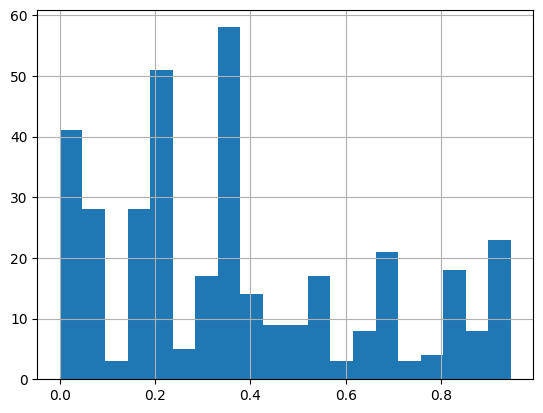

In [10]:
print(num_nulls['perc_nulls'].describe())
num_nulls['perc_nulls'].hist(bins = 20);

In [11]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X[num_cols])
X[num_cols] = imp_mean.transform(X[num_cols])
X_test[num_cols] = imp_mean.transform(X_test[num_cols])

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_num = X[num_cols].to_numpy()
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)
pca = PCA(random_state = 42)
X_num = pca.fit_transform(X_num)

Xt_num = X_test[num_cols].to_numpy()
Xt_num = scaler.transform(Xt_num)
Xt_num = pca.transform(Xt_num)

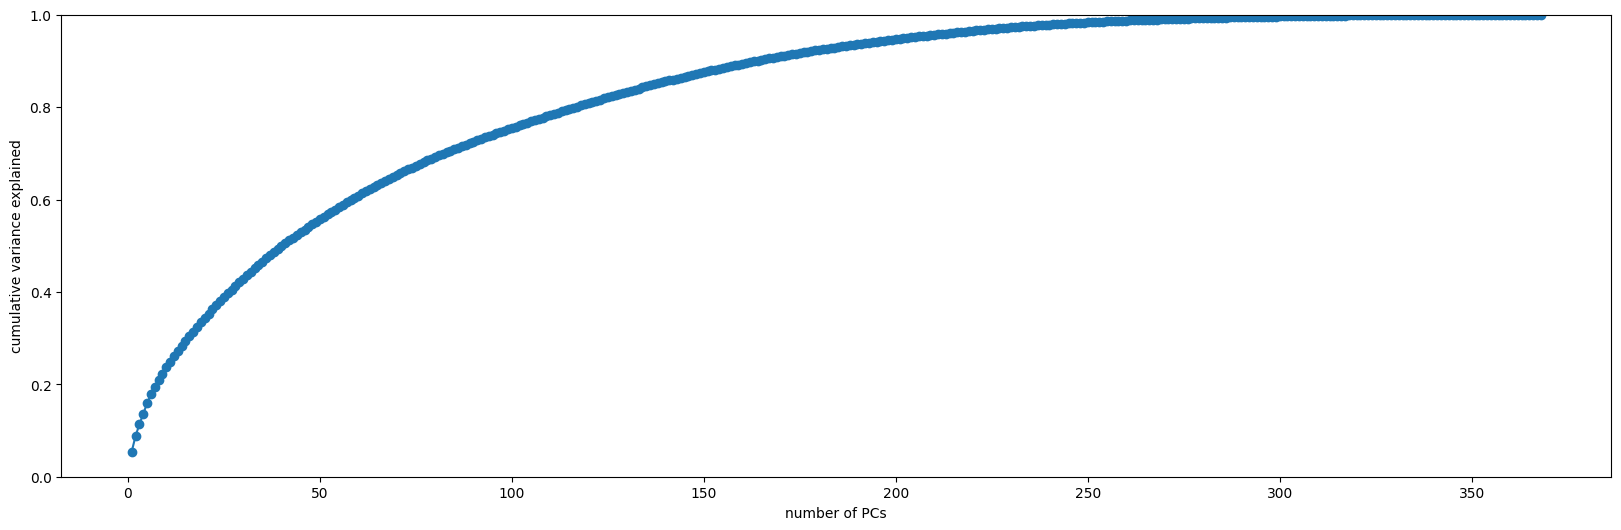

In [13]:
plt.figure(figsize=(20,6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), "o-"
)
plt.ylim(0, 1)
plt.xlabel("number of PCs")
plt.ylabel("cumulative variance explained");

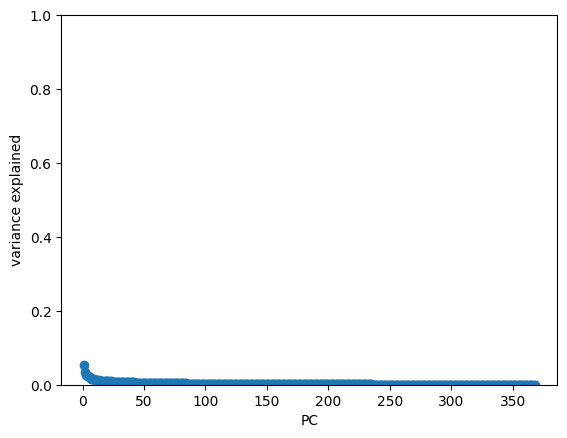

In [14]:
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'o-')
plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('variance explained');

In [15]:
pca_var = pd.DataFrame([list(pca.get_feature_names_out()), range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, pca.explained_variance_ratio_.cumsum()]).T
pca_var.columns = ["feature", "n_components", "explained_var", "cum_explained_var"]
pca_var

,feature,n_components,explained_var,cum_explained_var
0,pca0,1,0.054521,0.054521
1,pca1,2,0.033866,0.088387
2,pca2,3,0.024961,0.113348
3,pca3,4,0.023134,0.136482
4,pca4,5,0.022114,0.158596
...,...,...,...,...
363,pca363,364,0.0,1.0
364,pca364,365,0.0,1.0
365,pca365,366,0.0,1.0
366,pca366,367,0.0,1.0


In [16]:
pca_var[pca_var['cum_explained_var']<0.9]

,feature,n_components,explained_var,cum_explained_var
0,pca0,1,0.054521,0.054521
1,pca1,2,0.033866,0.088387
2,pca2,3,0.024961,0.113348
3,pca3,4,0.023134,0.136482
4,pca4,5,0.022114,0.158596
...,...,...,...,...
158,pca158,159,0.001771,0.891961
159,pca159,160,0.001749,0.89371
160,pca160,161,0.001732,0.895442
161,pca161,162,0.001716,0.897158


In [17]:
pca_var['feature'][163:]

163    pca163
164    pca164
165    pca165
166    pca166
167    pca167
        ...  
363    pca363
364    pca364
365    pca365
366    pca366
367    pca367
Name: feature, Length: 205, dtype: object

In [18]:
pca_var.to_csv("PCA_num_cols_explained_var.csv")

In [19]:
X_num = pd.DataFrame(X_num, columns = list(pca.get_feature_names_out()))
Xt_num = pd.DataFrame(Xt_num, columns = list(pca.get_feature_names_out()))

In [20]:
X = pd.concat([X_num, X[[x for x in X.columns if x not in num_cols]]], axis  =1)
X_test = pd.concat([Xt_num, X_test[[x for x in X_test.columns if x not in num_cols]]], axis  =1)

In [21]:
del X_num
del Xt_num

In [22]:
X.shape

(1221327, 450)

In [23]:
X_test.shape

(305332, 450)

##### Keep All Components

In [24]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X, y, X_test, y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_all.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0005862471015157272, 'acc': 0.9686112166428674, 'precision': 0.4134078212290503, 'recall': 0.007746257720087931, 'f1': 0.015207562679819153, 'roc_auc': 0.8335269269042165, 'pr_auc': 0.15804038534566595, 'lift': 13.21329811279267}"


In [25]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X, y, X_test, y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_all.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0006484744474866702, 'acc': 0.9686472430010611, 'precision': 0.4494949494949495, 'recall': 0.00931644509578143, 'f1': 0.018254537996102962, 'roc_auc': 0.8286195139951793, 'pr_auc': 0.1567560141917272, 'lift': 14.366711181743108}"


In [26]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums.csv', index = False)

#### Keep 99% Variance Explained

In [27]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.99]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

99


In [28]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_99.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0005076441381840095, 'acc': 0.9686374176306447, 'precision': 0.4258064516129032, 'recall': 0.006908824453051398, 'f1': 0.013597033374536464, 'roc_auc': 0.8289495542206973, 'pr_auc': 0.15497808474366911, 'lift': 13.609581857413481}"


In [29]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_99.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0005993475954043468, 'acc': 0.968624317136756, 'precision': 0.4262295081967213, 'recall': 0.008164974353606197, 'f1': 0.01602300739523418, 'roc_auc': 0.8249797466926883, 'pr_auc': 0.15349092660422564, 'lift': 13.623103548280257}"


In [30]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_99.csv', index = False)

#### Keep 95% of Variance Explained

In [31]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.95]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

165


In [32]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_95.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0005502207433220232, 'acc': 0.9685620897907851, 'precision': 0.3630952380952381, 'recall': 0.0063854286611535645, 'f1': 0.01255014916160889, 'roc_auc': 0.8273990180540084, 'pr_auc': 0.15340229440004574, 'lift': 11.605212523615121}"


In [33]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_95.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0005534958667941782, 'acc': 0.968624317136756, 'precision': 0.42011834319526625, 'recall': 0.007432220244949231, 'f1': 0.01460604813824316, 'roc_auc': 0.8227388548404011, 'pr_auc': 0.1523701208193661, 'lift': 13.427779123259398}"


In [34]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_95.csv', index = False)

#### Keep 90% of Variance Explained

In [35]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.90]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

205


In [36]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_90.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0005600461137384879, 'acc': 0.9685981161489788, 'precision': 0.39766081871345027, 'recall': 0.007118182769810531, 'f1': 0.013986013986013986, 'roc_auc': 0.8258763321302725, 'pr_auc': 0.1529388163661713, 'lift': 12.709994043694673}"


In [37]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_90.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0005469456198498683, 'acc': 0.968624317136756, 'precision': 0.41916167664670656, 'recall': 0.007327541086569664, 'f1': 0.014403292181069957, 'roc_auc': 0.8215957183258102, 'pr_auc': 0.15165925834081678, 'lift': 13.39720224577538}"


In [38]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_90.csv', index = False)

#### Keep 85% of Variance Explained

In [39]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.85]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

231


In [40]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_85.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0005665963606827977, 'acc': 0.9685981161489788, 'precision': 0.3988439306358382, 'recall': 0.007222861928190097, 'f1': 0.01418877236273905, 'roc_auc': 0.825236673704313, 'pr_auc': 0.15239733752012433, 'lift': 12.747808544844734}"


In [41]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_85.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0005829719780435723, 'acc': 0.9686537932480055, 'precision': 0.449438202247191, 'recall': 0.008374332670365331, 'f1': 0.016442297811119104, 'roc_auc': 0.8208139604170666, 'pr_auc': 0.15053817119774504, 'lift': 14.364897432067343}"


In [42]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_85.csv', index = False)

#### Keep 80% of Variance Explained

In [43]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.80]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

252


In [44]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_80.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0004323162983244468, 'acc': 0.9686603434949498, 'precision': 0.4393939393939394, 'recall': 0.006071391186014865, 'f1': 0.011977284460505938, 'roc_auc': 0.8246590465070947, 'pr_auc': 0.15219813877222965, 'lift': 14.043863739456748}"


In [45]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_80.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0005305700024890938, 'acc': 0.9686079415193953, 'precision': 0.4012345679012346, 'recall': 0.0068041452946718305, 'f1': 0.013381369016984045, 'roc_auc': 0.8208317270550963, 'pr_auc': 0.1504323142545413, 'lift': 12.824217846374934}"


In [46]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_80.csv', index = False)

#### Keep 70% of Variance Explained

In [47]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.70]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

286


In [48]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_70.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0004847182738789252, 'acc': 0.9686144917663396, 'precision': 0.39864864864864863, 'recall': 0.006176070344394431, 'f1': 0.012163694464488197, 'roc_auc': 0.8232146235422764, 'pr_auc': 0.15114865075017725, 'lift': 12.74156696212595}"


In [49]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_70.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.00048799339735108014, 'acc': 0.9686046663959231, 'precision': 0.38926174496644295, 'recall': 0.006071391186014865, 'f1': 0.011956297670583387, 'roc_auc': 0.8195584638344496, 'pr_auc': 0.14935120270064972, 'lift': 12.441543715491884}"


In [50]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_70.csv', index = False)

#### Keep 60% of Variance Explained

In [51]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.60]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

310


In [52]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_60.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.00042249092790798214, 'acc': 0.9686898196061992, 'precision': 0.4728682170542636, 'recall': 0.0063854286611535645, 'f1': 0.012600702334228466, 'roc_auc': 0.8222818338151927, 'pr_auc': 0.149612670395037, 'lift': 15.113765147033645}"


In [53]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_60.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0004552421626295311, 'acc': 0.9686177668898117, 'precision': 0.39568345323741005, 'recall': 0.005757353710876164, 'f1': 0.011349566652909615, 'roc_auc': 0.8171393411153474, 'pr_auc': 0.1466035173781538, 'lift': 12.646793692440584}"


In [54]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_60.csv', index = False)

#### Keep 50% of Variance Explained

In [55]:
pca_cols = list(pca_var[pca_var['cum_explained_var']>0.50]['feature'])
cols = [x for x in X.columns if x not in pca_cols]
print(len(pca_cols))

328


In [56]:
lgb, lgb_pred, lgb_scores = Model_Utils.LightGBMClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_lgb)
with open('lgb_train_pca_num_50.joblib', 'wb') as f:
    joblib.dump(lgb, f)

LightGBM, Test: {'event_rate': 0.0003242372237433351, 'acc': 0.9686701688653663, 'precision': 0.43434343434343436, 'recall': 0.004501203810321365, 'f1': 0.008910070451719852, 'roc_auc': 0.8197870504377129, 'pr_auc': 0.146747688358744, 'lift': 13.882440018313567}"


In [57]:
clf, y_pred, cat_scores = Model_Utils.CatBoostClassifier_pred(X[cols], y, X_test[cols], y_test, cat_cols, params_catboost)
with open('catboost_train_pca_num_50.joblib', 'wb') as f:
    joblib.dump(clf, f)

CatBoost, Test: {'event_rate': 0.0003700889523535037, 'acc': 0.9686701688653663, 'precision': 0.4424778761061947, 'recall': 0.005233957918978332, 'f1': 0.010345541071798055, 'roc_auc': 0.8166224268319628, 'pr_auc': 0.14382439983402073, 'lift': 14.142432206349488}"


In [58]:
model_save = id_test_val
model_save['target'] = y_test
model_save['catboost'] = cat_scores
model_save['lgb'] = lgb_scores
model_save.to_csv('Test_predictions_PCA_nums_50.csv', index = False)